In [49]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import math
import seaborn as sns
import plotly.graph_objects as go


In [50]:
#Reading data
#Spanish data from spanish health ministry, all hisotrical series
data = pd.read_csv(r"https://covid19.isciii.es/resources/serie_historica_acumulados.csv",skipfooter=3,error_bad_lines=False,encoding = 'ANSI')

data.columns = ['CCAA Codigo ISO','Fecha','Casos Old','Casos','TestAc','Hospitalizados','UCI','Fallecidos','Recuperados']
#World data from Johns Hopkins University (github)
#Confirmed cases
data_jh_conf = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Confirmed deaths
data_jh_muertos = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Confirmed recovered
data_jh_recuperados = pd.read_csv(r"https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv", 
                           error_bad_lines=False,encoding = 'ANSI')

#Cataluña data
data_cat = pd.read_csv(r"https://analisi.transparenciacatalunya.cat/api/views/jj6z-iyrp/rows.csv?accessType=DOWNLOAD&bom=true&format=true&delimiter=%3B&sorting=true", sep=";",encoding = 'utf-8')

#Spanish data from Madrid
data_madrid = pd.read_csv(r"https://datos.comunidad.madrid/catalogo/dataset/7da43feb-8d4d-47e0-abd5-3d022d29d09e/resource/b2a3a3f9-1f82-42c2-89c7-cbd3ef801412/download/covid19_tia_muni_y_distritos.csv", sep=";",encoding = 'ANSI')

#datos de renta por municipios
data_renta_municipios = pd.read_csv(r"C:\Users\guillermo.arguello\Documents\Covid Analisys\renta_municipios.csv", sep="|",encoding = 'ANSI')

#datos población paises

data_poblacion = pd.read_excel('https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/EXCEL_FILES/1_Population/WPP2019_POP_F01_1_TOTAL_POPULATION_BOTH_SEXES.xlsx',
                                    sheet_name="ESTIMATES",skiprows= 16)

data_poblacion = data_poblacion[["Region, subregion, country or area *","2020"]]

data["Casos"] =  np.where(data["Casos"].isna(), data["Casos Old"],data["Casos"])


In [51]:
#Transpose Johns Hopkins Data

data_jh_conf = data_jh_conf.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Casos')
data_jh_muertos = data_jh_muertos.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Fallecidos')
data_jh_recuperados = data_jh_recuperados.melt(['Province/State', 'Country/Region',"Lat","Long"], var_name='Fecha', value_name='Recuperados')

#Join all data in one dataframe
data_jh = pd.merge(data_jh_conf, data_jh_muertos, left_on=['Province/State','Country/Region','Fecha','Lat','Long'], 
                   right_on = ['Province/State','Country/Region','Fecha','Lat','Long'])

data_jh = pd.merge(data_jh, data_jh_recuperados, how= 'left',left_on=['Province/State','Country/Region','Fecha','Lat','Long'], 
                   right_on = ['Province/State','Country/Region','Fecha','Lat','Long'])

#Removing Province/State, Lat and long data, we won´t use it (it could be usefull for geographical plots)

data_jh = data_jh.drop(["Province/State","Lat","Long"], axis=1)


In [52]:
data_jh = data_jh.dropna()
data_jh = data_jh.groupby(['Fecha','Country/Region'], as_index=False).sum()
data_jh = data_jh.sort_values(by=['Fecha'])
data_jh["Fecha2"] = pd.to_datetime(data_jh["Fecha"], format="%m/%d/%y").dt.strftime('%Y%m%d').astype(int).sort_values(ascending=False)
data_jh["Fecha"] = pd.to_datetime(data_jh["Fecha"], format="%m/%d/%y")
data_jh["Casos"] = pd.to_numeric(data_jh["Casos"])
data_jh["Fallecidos"] = pd.to_numeric(data_jh["Fallecidos"])
data_jh["Recuperados"] = pd.to_numeric(data_jh["Recuperados"])
data_jh["Country/Region"] = data_jh["Country/Region"].astype(str)

data_jh = data_jh.set_index('Fecha2')
data_jh = data_jh.sort_index()
data_jh = data_jh.reset_index()

data_jh['Diferencia casos dia anterior'] = data_jh.groupby('Country/Region', as_index=True).diff(1)["Casos"]
data_jh['Diferencia fallecidos dia anterior'] = data_jh.groupby('Country/Region', as_index=True).diff(1)["Fallecidos"]
data_jh['Diferencia recuperados dia anterior'] = data_jh.groupby('Country/Region', as_index=True).diff(1)["Recuperados"]
data_jh = data_jh.fillna(0)
data_jh = data_jh.drop(["Fecha2"], axis=1)

data_jh = pd.merge(data_jh, data_poblacion, how= 'left',left_on=['Country/Region'], 
                   right_on = ['Region, subregion, country or area *'])

data_jh = data_jh.set_index('Fecha')
data_jh["Incremento porcentual de casos respecto al total"]= data_jh["Diferencia casos dia anterior"]/data_jh["Casos"]*100
data_jh["Incremento porcentual de fallecidos respecto al total"]= data_jh["Diferencia fallecidos dia anterior"]/data_jh["Fallecidos"]*100

data_jh = data_jh.rename(columns={"2020": "2020 Population"})

data_jh["Fallecidos por millón habitantes"]= data_jh["Fallecidos"]/(data_jh["2020 Population"]/1000)


data_sem_jh = data_jh.groupby(['Country/Region'], as_index=True).rolling(7, center=False).mean()

In [53]:
data = data.fillna(0)
data.drop(data[ data['Fecha'] == 0 ].index , inplace=True)
data["Fecha"] = pd.to_datetime(data["Fecha"], format="%d/%m/%Y").sort_values()
data['Diferencia casos dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=True).diff(1)["Casos"]
data['Diferencia hospitalizados dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=True).diff(1)["Hospitalizados"]
data['Diferencia UCI dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=True).diff(1)["UCI"]
data['Diferencia fallecidos dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=True).diff(1)["Fallecidos"]
data['Diferencia recuperados dia anterior'] = data.groupby('CCAA Codigo ISO', as_index=True).diff(1)["Recuperados"]

data = data.fillna(0)
data_es = data.groupby('Fecha', as_index=False).sum()
data_es = data_es.set_index('Fecha')
data_es = data_es[data_es["Fallecidos"] > 10]
data_es["Incremento porcentual de casos respecto al total"]= (data_es["Diferencia casos dia anterior"]/data_es["Casos"]*100).round(3)
data_es["Incremento porcentual de fallecidos respecto al total"]= (data_es["Diferencia fallecidos dia anterior"]/data_es["Fallecidos"]*100).round(3)

data_sem = data_es.rolling(7, center=False).mean()


In [54]:
data_cat["Data"] = pd.to_datetime(data_cat["TipusCasData"], format="%d/%m/%Y").sort_values()
data_cat_gropued = data_cat.groupby('Data',as_index = False).sum().sort_values('Data',ascending=True)
data_cat_gropued = data_cat_gropued[data_cat_gropued["Data"] > "2020-03-01"]
data_cat_gropued = data_cat_gropued.set_index('Data')
data_cat_gropued_resultado = data_cat.groupby(['Data',"TipusCasDescripcio"],as_index = False).sum().sort_values('Data',ascending=True)
data_cat_gropued_resultado = data_cat_gropued_resultado[data_cat_gropued_resultado["Data"] > "2020-03-01"]
data_cat_gropued_resultado = data_cat_gropued_resultado.set_index('Data')

In [55]:
#Procasamiento datos Madrid
data_madrid = data_madrid[["municipio_distrito","fecha_informe","casos_confirmados_totales","tasa_incidencia_acumulada_total"]]
data_madrid = data_madrid.dropna()
data_madrid["municipio_distrito"]= data_madrid["municipio_distrito"].str.strip()
data_renta_municipios["MUNICIPIO"]= data_renta_municipios["MUNICIPIO"].str.strip()

data_renta_municipios = data_renta_municipios[["MUNICIPIO","RENTA DISPONIBLE MEDIA","NUMERO HABITANTES"]]
data_mad = pd.merge(data_madrid, data_renta_municipios, how= 'left',left_on=['municipio_distrito'], 
                   right_on = ['MUNICIPIO'])

data_mad["tasa_incidencia_acumulada_total"] = data_mad["tasa_incidencia_acumulada_total"].str.replace(",",".")
data_mad["tasa_incidencia_acumulada_total"] = pd.to_numeric(data_mad["tasa_incidencia_acumulada_total"])
data_mad["NUMERO HABITANTES"] = data_mad["NUMERO HABITANTES"].str.replace(".","")
data_mad["NUMERO HABITANTES"] = pd.to_numeric(data_mad["NUMERO HABITANTES"])


#data_mad = data_mad.dropna(subset = ["RENTA BRUTA MEDIA"])
#data_mad = data_mad.dropna()


data_mad.loc[data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*0.85 , "Renta Categorical"] = 'Renta Baja'

data_mad.loc[(data_mad["RENTA DISPONIBLE MEDIA"] >= data_mad["RENTA DISPONIBLE MEDIA"].median()*0.85) & 
         (data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*1), "Renta Categorical"] = 'Renta Media-Baja'

data_mad.loc[(data_mad["RENTA DISPONIBLE MEDIA"] >= data_mad["RENTA DISPONIBLE MEDIA"].median()*1) & 
         (data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*1.25), "Renta Categorical"] = 'Renta Media-Media'

data_mad.loc[(data_mad["RENTA DISPONIBLE MEDIA"] >= data_mad["RENTA DISPONIBLE MEDIA"].median()*1.25) & 
         (data_mad["RENTA DISPONIBLE MEDIA"] < data_mad["RENTA DISPONIBLE MEDIA"].median()*1.5), "Renta Categorical"] = 'Renta Media-Alta'

data_mad.loc[data_mad["RENTA DISPONIBLE MEDIA"] > data_mad["RENTA DISPONIBLE MEDIA"].median()*1.5, "Renta Categorical"] = 'Renta Alta'


data_mad = data_mad[data_mad["NUMERO HABITANTES"] > 1000] 
data_mad = data_mad[data_mad["casos_confirmados_totales"] > 20] 


In [56]:
data_es.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\data_es_historical_series.csv')
data_jh.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\john_hopkins_university_historical_series.csv')
data_cat_gropued.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\data_catalunya.csv')
data_mad.to_csv(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\data_madrid.csv')


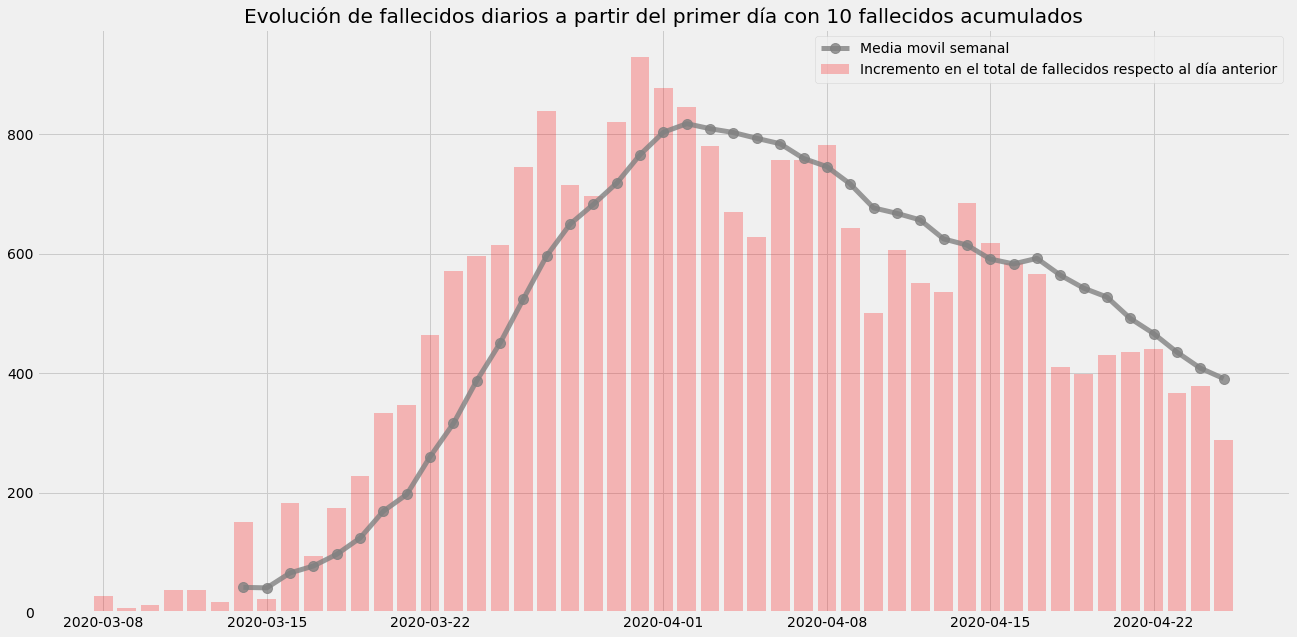

In [57]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_sem['Diferencia fallecidos dia anterior'],alpha=1.8,color='grey',
         label='Media movil semanal',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Diferencia fallecidos dia anterior"],width=0.8, alpha=0.25, color='red',
       label='Incremento en el total de fallecidos respecto al día anterior')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de fallecidos diarios a partir del primer día con 10 fallecidos acumulados')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\fallecidos.png');



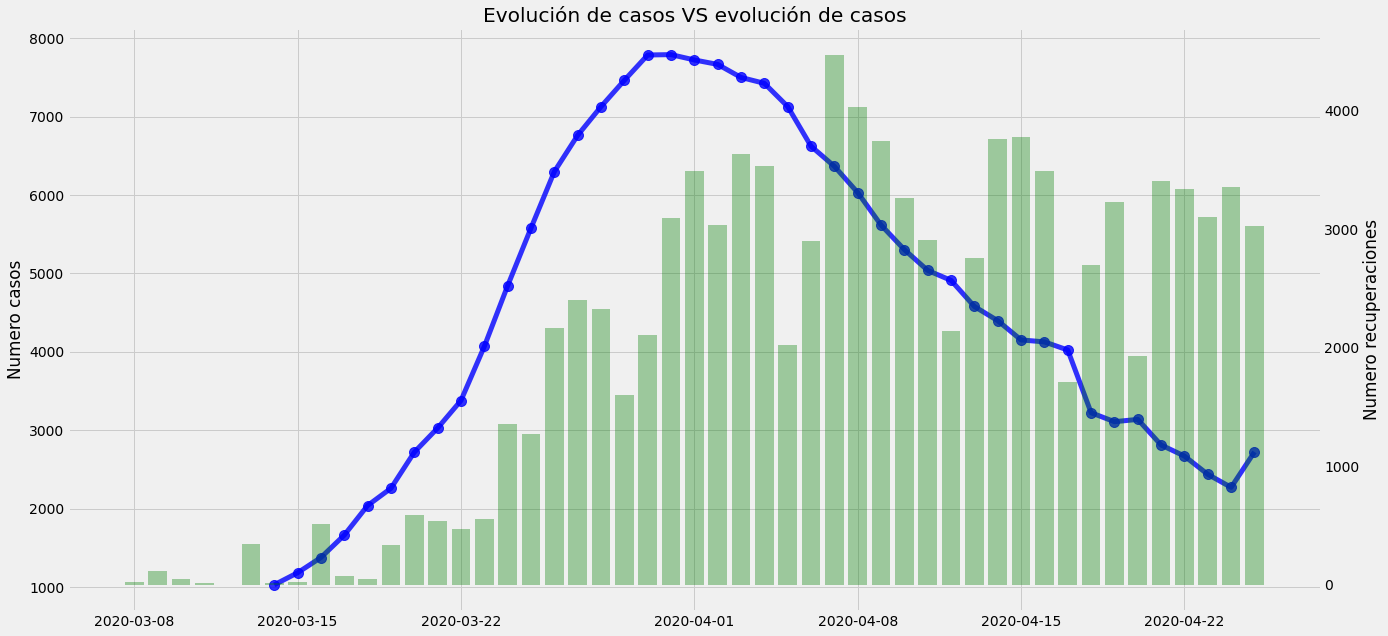

In [58]:
# Let's build our plot
# Set up plot 

fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1.twinx()  # set up the 2nd axis

#Next lines plot the line of the plot

ax1.plot(data_sem['Diferencia casos dia anterior'],alpha=0.8,color='blue',
         label='Incremento en el total de casos respecto al día anterior',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_sem.index, data_es["Diferencia recuperados dia anterior"],width=0.8, alpha=0.35, color='green',
       label='Incremento en el total de recuperados respecto al día anterior')


ax2.grid(b=False) # turn off grid #2

ax1.set_title('Evolución de casos VS evolución de casos')
ax1.set_ylabel('Numero casos')
ax2.set_ylabel('Numero recuperaciones');



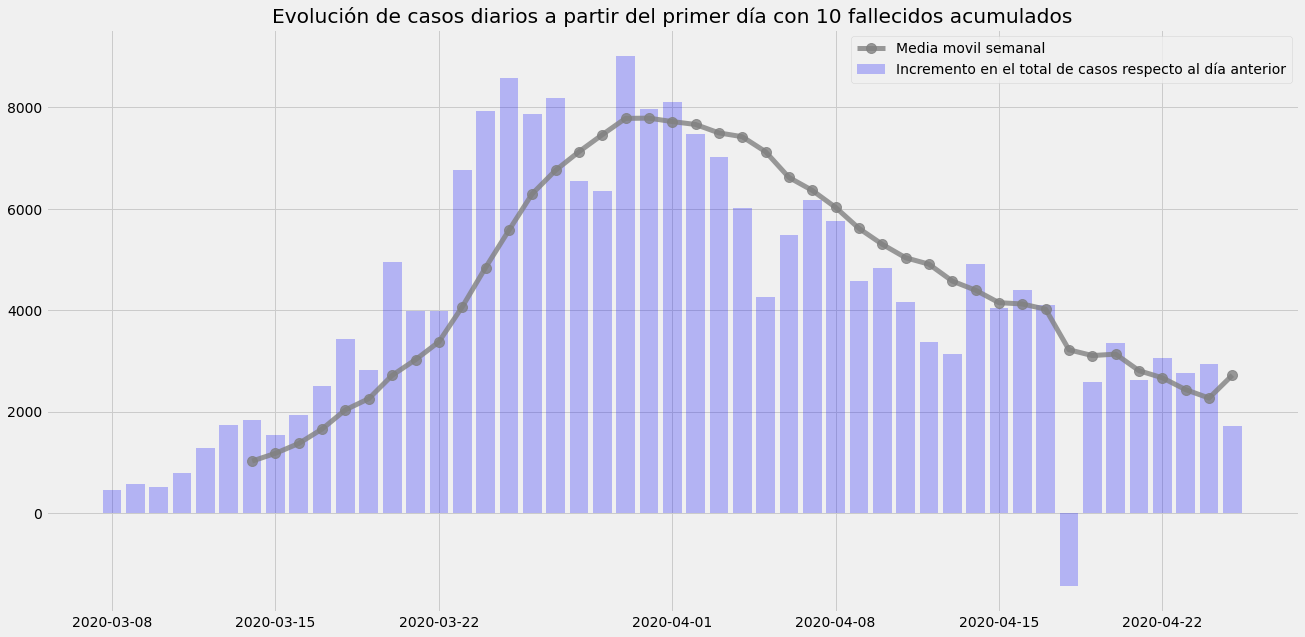

In [59]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_sem['Diferencia casos dia anterior'],alpha=1.8,color='grey',
         label='Media movil semanal',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Diferencia casos dia anterior"],width=0.8, alpha=0.25, color='blue',
       label='Incremento en el total de casos respecto al día anterior')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de casos diarios a partir del primer día con 10 fallecidos acumulados')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\casos.png');




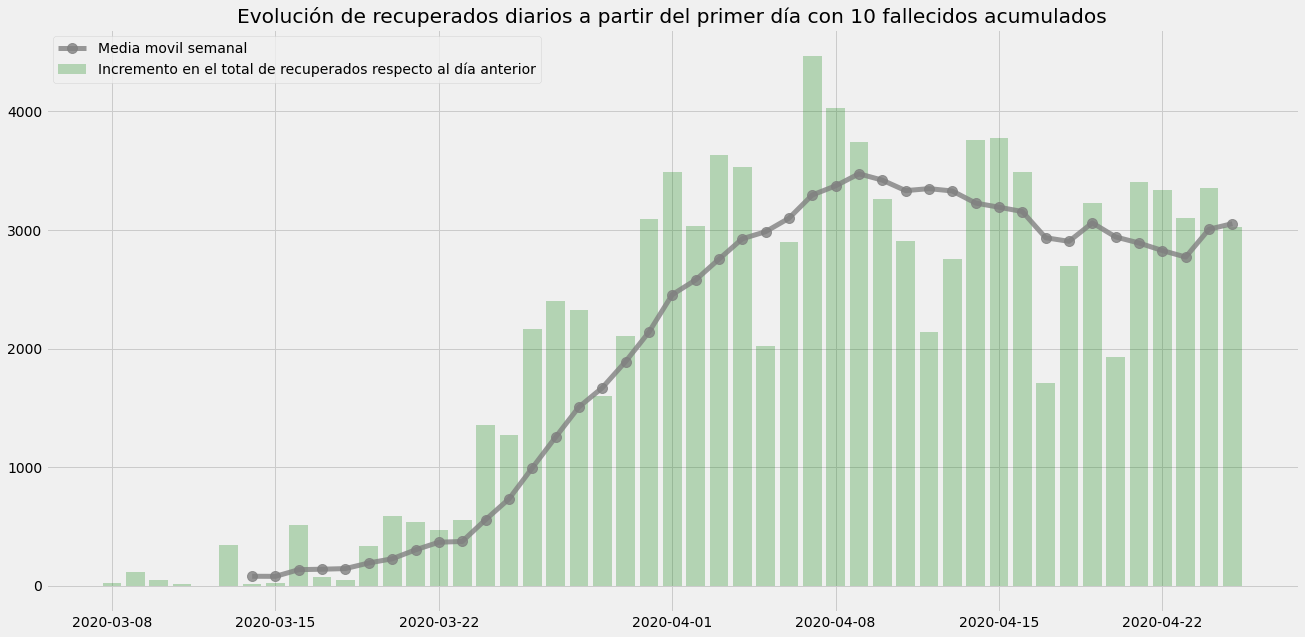

In [60]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_sem['Diferencia recuperados dia anterior'],alpha=1.8,color='grey',
         label='Media movil semanal',marker='o', markersize=10,linewidth=5)

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Diferencia recuperados dia anterior"],width=0.8, alpha=0.25, color='green',
       label='Incremento en el total de recuperados respecto al día anterior')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de recuperados diarios a partir del primer día con 10 fallecidos acumulados')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\recuperados.png');


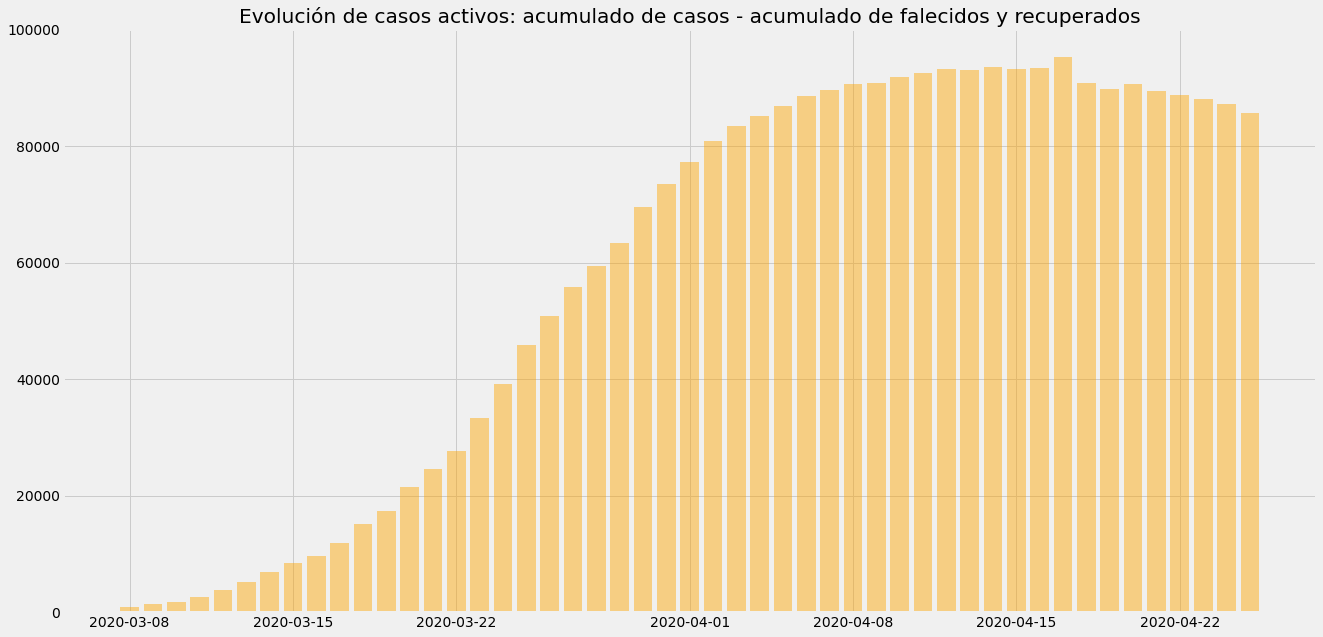

In [61]:
# Let's build our plot
# Set up plot 
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the bar chat part of the plot
ax2.bar(data_es.index, data_es["Casos"] - data_es["Fallecidos"] - data_es["Recuperados"],
        width=0.8, alpha=0.45, color='orange')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Evolución de casos activos: acumulado de casos - acumulado de falecidos y recuperados')
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\casos_activos.png');


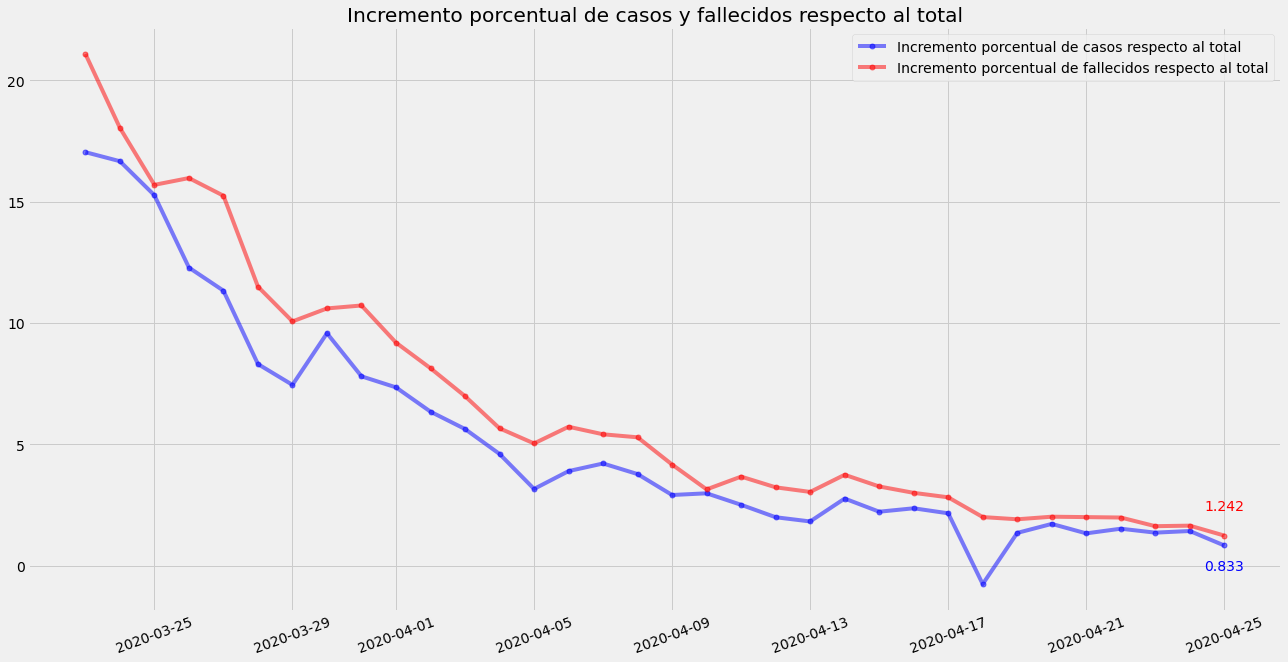

In [62]:
start, end = '2020-03-23 00:00:00', data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-',alpha=0.5,color='blue',
        label='Incremento porcentual de casos respecto al total')

ax.plot(data_es.loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, alpha=0.5,color='red',linestyle='-', label='Incremento porcentual de fallecidos respecto al total')

plt.xticks(rotation=20)
plt.title("Incremento porcentual de casos y fallecidos respecto al total")

plt.annotate(data_es.loc[end, 'Incremento porcentual de casos respecto al total'], # this is the text
                 (end,data_es.loc[end, 'Incremento porcentual de casos respecto al total']), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-25), # distance from text to points (x,y)
                 ha='center',color='blue') # horizontal alignment can be left, right or center
plt.annotate(data_es.loc[end, 'Incremento porcentual de fallecidos respecto al total'], # this is the text
                 (end,data_es.loc[end, 'Incremento porcentual de fallecidos respecto al total']), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,25), # distance from text to points (x,y)
                 ha='center',color='red') # horizontal alignment can be left, right or center

ax.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\incremento_porcentual.png');


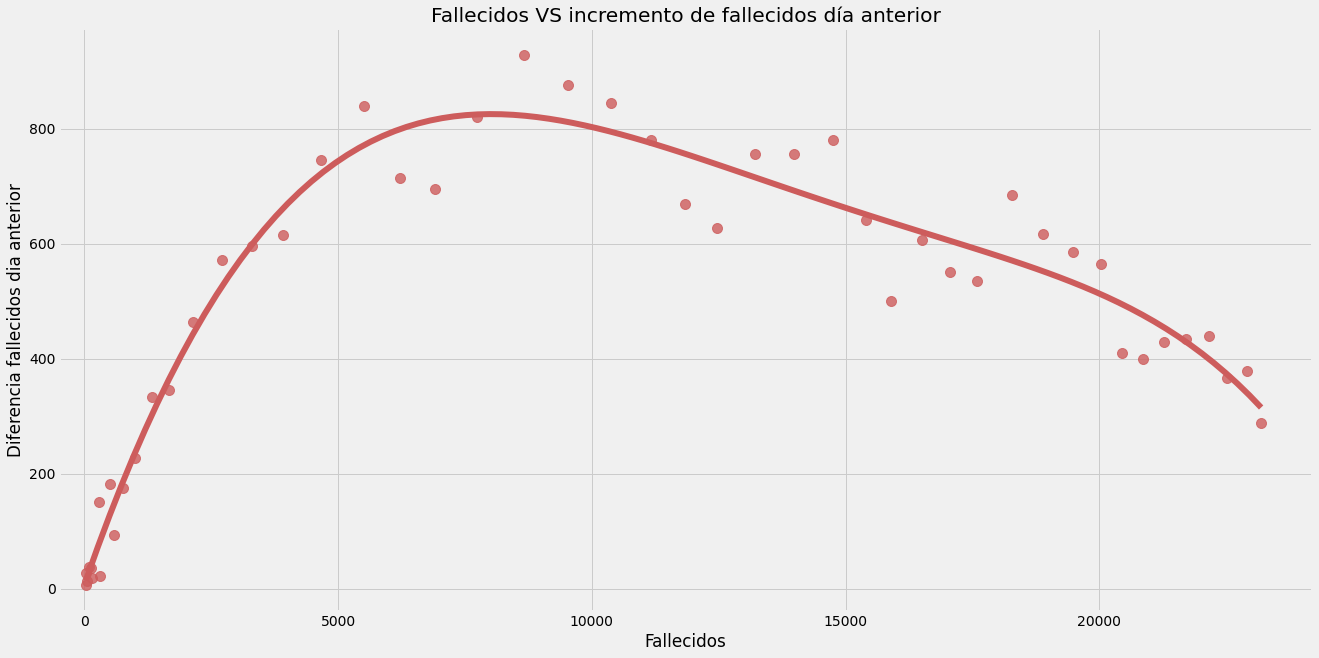

In [63]:
fig, ax = plt.subplots(figsize=(20,10))

start, end = data_es.index.min(), data_es.index.max()
X = data_es.loc[start:end, 'Fallecidos']
Y = data_es.loc[start:end, 'Diferencia fallecidos dia anterior']

ax = sns.regplot(x=X, y=Y, data=data_es,scatter_kws={"s": 100},order=5, ci=False,color='indianred')
plt.title("Fallecidos VS incremento de fallecidos día anterior")
ax.set(xlim=(-500, data_es["Fallecidos"].max() + 1000))
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\fallecidos_VS_incremento.png');



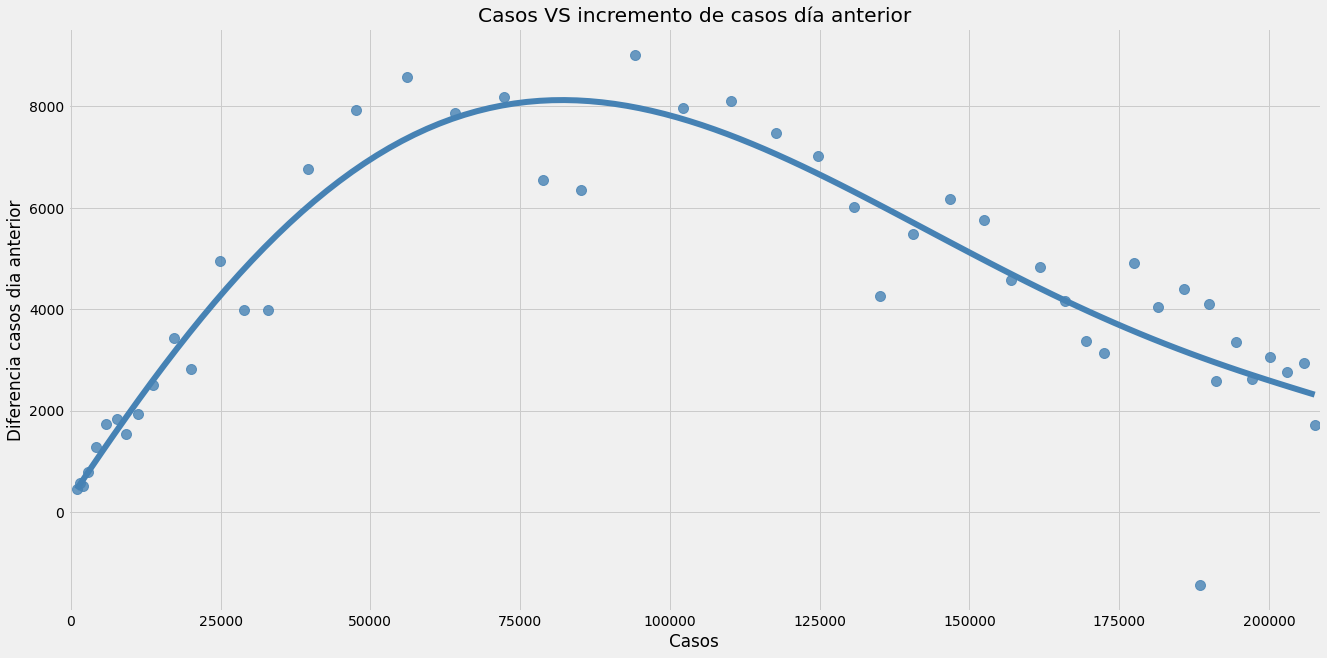

In [64]:
fig, ax = plt.subplots(figsize=(20,10))

start, end = data_es.index.min(), data_es.index.max()
X = data_es.loc[start:end, 'Casos']
Y = data_es.loc[start:end, 'Diferencia casos dia anterior']

ax = sns.regplot(x=X, y=Y, data=data_es,scatter_kws={"s": 100},order=5, ci=True,color='steelblue')
ax.set(xlim=(-500, data_es["Casos"].max() + 1000))

plt.title("Casos VS incremento de casos día anterior")
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\casos_VS_incremento.png');



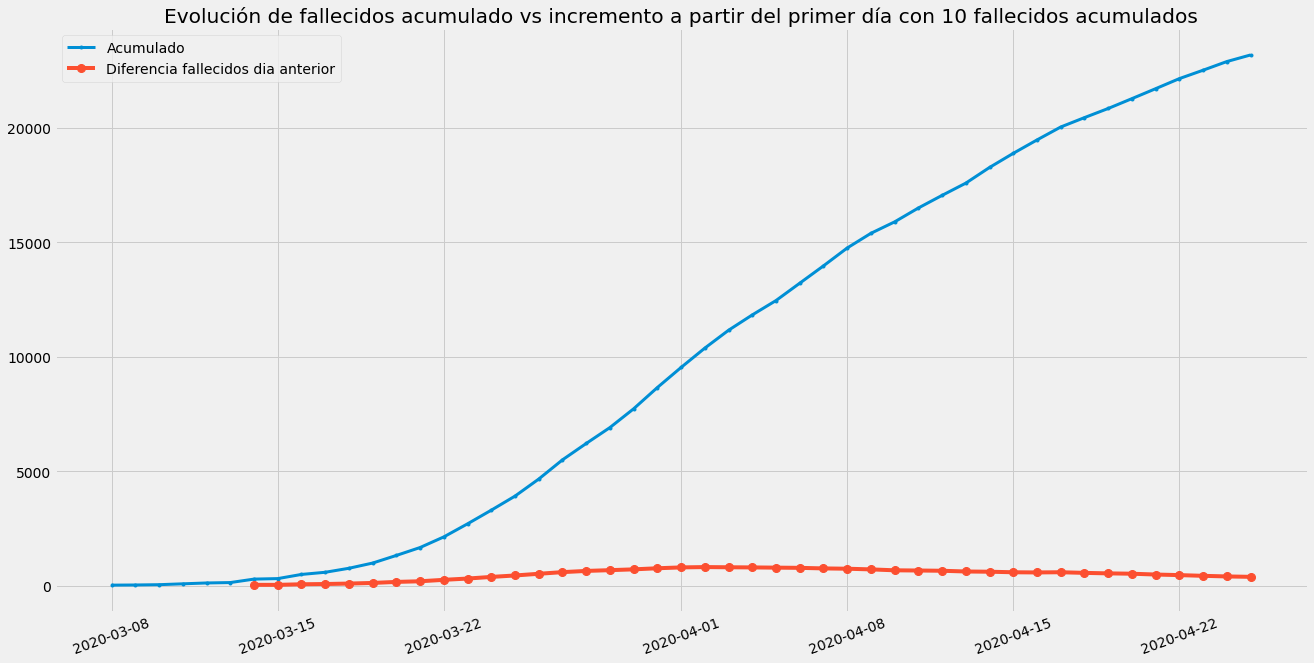

In [65]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Fallecidos'],
marker='.', linestyle='-', linewidth=3, label='Acumulado')
ax.plot(data_sem.loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=8, linestyle='-', label='Diferencia fallecidos dia anterior')
plt.xticks(rotation=20)
plt.title("Evolución de fallecidos acumulado vs incremento a partir del primer día con 10 fallecidos acumulados")
ax.legend();

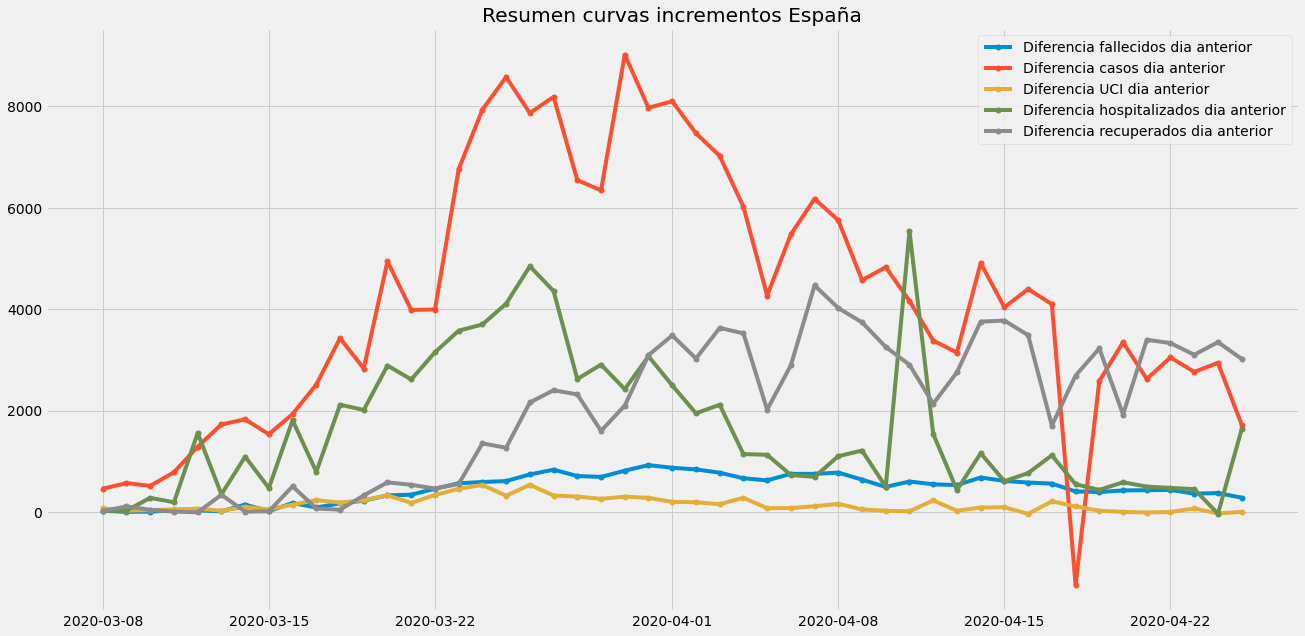

In [66]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_es.loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia fallecidos dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia casos dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia UCI dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia UCI dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia hospitalizados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia hospitalizados dia anterior')
ax.plot(data_es.loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia recuperados dia anterior')
plt.title("Resumen curvas incrementos España");
ax.legend();

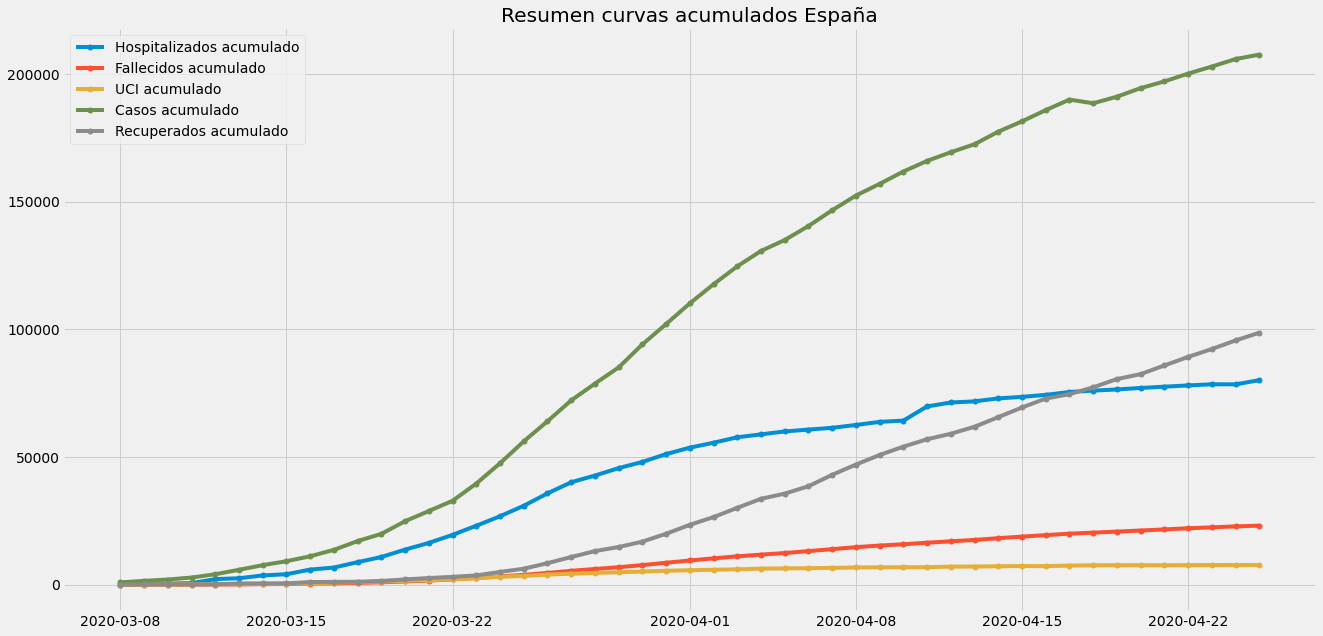

In [67]:
start, end = data_es.index.min(), data_es.index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))

ax.plot(data_es.loc[start:end, 'Hospitalizados'],
marker='o', markersize=5, linestyle='-', label='Hospitalizados acumulado')
ax.plot(data_es.loc[start:end, 'Fallecidos'],
marker='o', markersize=5, linestyle='-', label='Fallecidos acumulado')
ax.plot(data_es.loc[start:end, 'UCI'],
marker='o', markersize=5, linestyle='-', label='UCI acumulado')
ax.plot(data_es.loc[start:end, 'Casos'],
marker='o', markersize=5, linestyle='-', label='Casos acumulado')
ax.plot(data_es.loc[start:end, 'Recuperados'],
marker='o', markersize=5, linestyle='-', label='Recuperados acumulado')
plt.title("Resumen curvas acumulados España");
ax.legend();

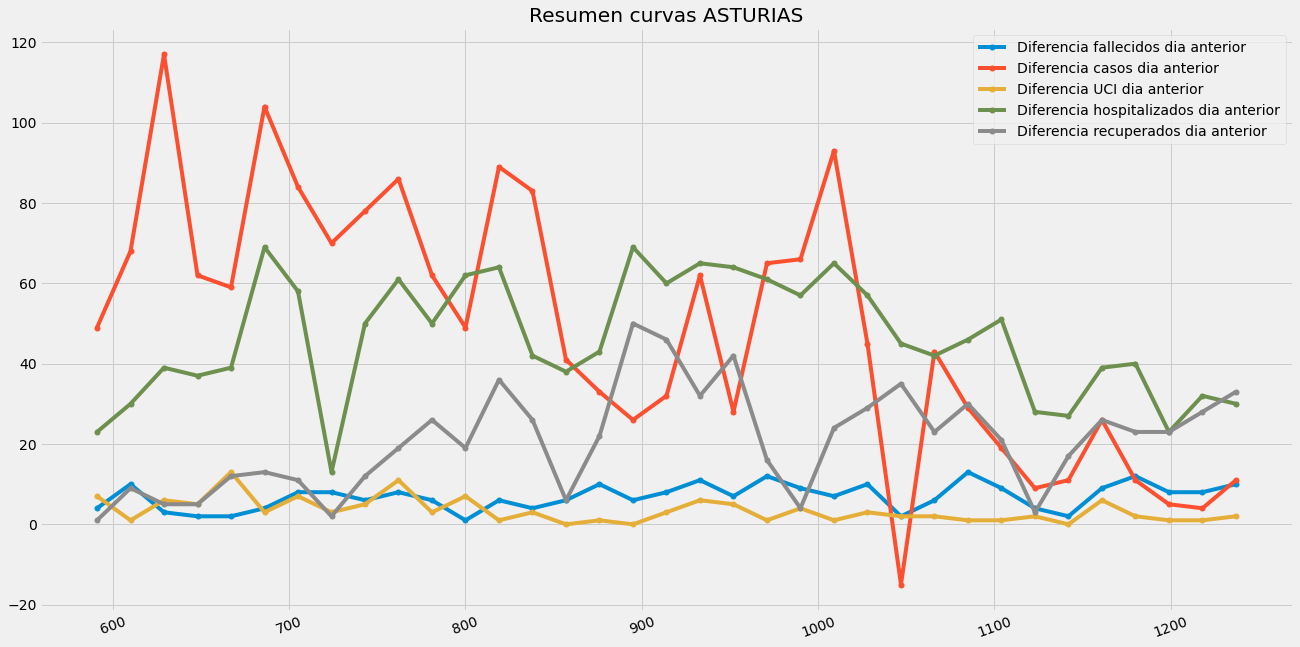

In [68]:
#Introducir código ISO de la comunidad a analizar (ejemplo Asturias) 
data = data[data["Fallecidos"] > 10]

start, end = data[data["CCAA Codigo ISO"] == "AS"].index.min(), data[data["CCAA Codigo ISO"] == "AS"].index.max()
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia fallecidos dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia casos dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia UCI dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia UCI dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia hospitalizados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia hospitalizados dia anterior')
ax.plot(data[data["CCAA Codigo ISO"] == "AS"].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Diferencia recuperados dia anterior')
ax.legend()
plt.xticks(rotation=20)
plt.title("Resumen curvas ASTURIAS");

Casos positivos: 47725
Casos Sospechosos: 93639
Numero de tests totales: 141364


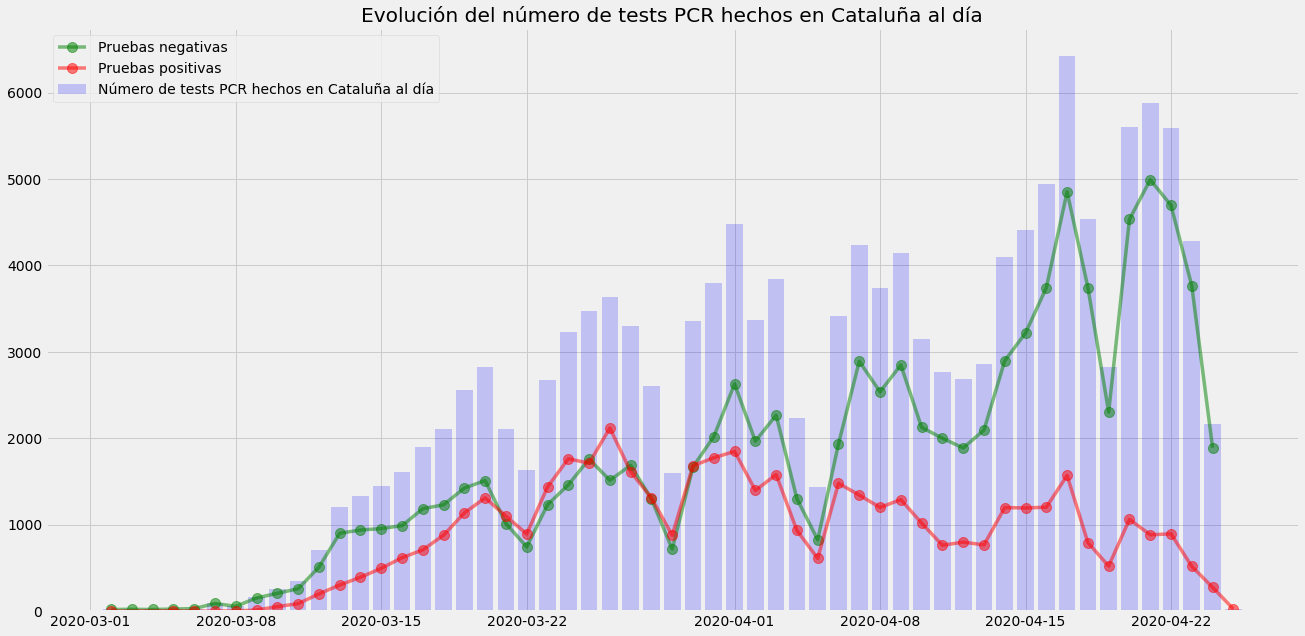

In [69]:
fig, ax1 = plt.subplots(figsize=(20,10))
ax2 = ax1 # set up the 2nd axis

#Next lines plot the line of the plot
ax1.plot(data_cat_gropued_resultado[data_cat_gropued_resultado['TipusCasDescripcio'] == "Sospitós"]["NumCasos"]
         ,alpha=0.5,color='green',
         label='Pruebas negativas',marker='o', markersize=10,linewidth=3.5)

ax1.plot(data_cat_gropued_resultado[data_cat_gropued_resultado['TipusCasDescripcio'] == "Positiu"]["NumCasos"]
         ,alpha=0.5,color='red',
         label='Pruebas positivas',marker='o', markersize=10,linewidth=3.5)


#Next lines plot the bar chat part of the plot
ax2.bar(data_cat_gropued.index, data_cat_gropued["NumCasos"],width=0.8, alpha=0.2, color='blue',
       label='Número de tests PCR hechos en Cataluña al día')

ax1.grid(b=True) #Turn on grid

print ("Casos positivos:", data_cat_gropued_resultado[data_cat_gropued_resultado['TipusCasDescripcio'] == "Positiu"]["NumCasos"].sum())
print ("Casos Sospechosos:", data_cat_gropued_resultado[data_cat_gropued_resultado['TipusCasDescripcio'] == "Sospitós"]["NumCasos"].sum())
print ("Numero de tests totales:", data_cat_gropued_resultado["NumCasos"].sum())

#set up the title and legend
ax1.set_title('Evolución del número de tests PCR hechos en Cataluña al día')
ax1.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\tests.png');



In [70]:
data_sem_jh = data_sem_jh[data_sem_jh["Fallecidos"] >= 10]
data_sem_jh = data_sem_jh.reset_index()
data_sem_jh = data_sem_jh.set_index('Fecha')
data_sem_jh = data_sem_jh.reset_index()
data_sem_jh["Time_delta"] = 0
data_sem_jh["Time_delta"] = pd.to_timedelta(data_sem_jh["Time_delta"])


In [71]:
for geo in data_sem_jh["Country/Region"].unique():
    data_sem_out = data_sem_jh[data_sem_jh["Country/Region"] == geo]
    data_sem_out["Time_delta"] = data_sem_out[data_sem_out["Country/Region"] == geo]["Fecha"] - data_sem_out[data_sem_out["Country/Region"] == geo]["Fecha"].min()
    data_sem_jh[data_sem_jh["Country/Region"] == geo] = data_sem_out[data_sem_out["Country/Region"] == geo]

In [72]:
data_sem_jh["Time_delta"] = data_sem_jh["Time_delta"].astype('timedelta64[D]')
data_sem_jh = data_sem_jh.set_index('Time_delta')


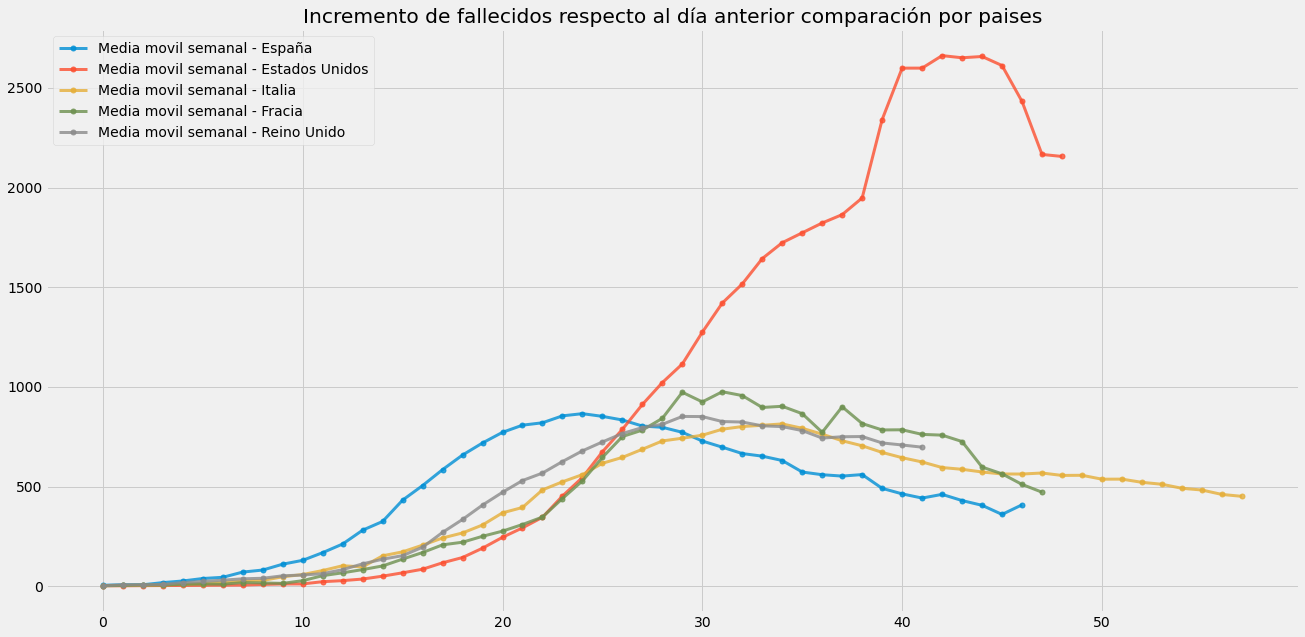

In [73]:
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o', alpha=0.8,linewidth=3, markersize=5, linestyle='-', label='Media movil semanal - España')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o', alpha=0.8,linewidth=3,markersize=5, linestyle='-', label='Media movil semanal - Estados Unidos')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o',alpha=0.8,linewidth=3, markersize=5, linestyle='-', label='Media movil semanal - Italia')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & 
                    (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o',alpha=0.8 ,linewidth=3,markersize=5, linestyle='-', label='Media movil semanal - Fracia')

ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") 
                    & (data_sem_jh["Fallecidos"] > 10)]['Diferencia fallecidos dia anterior'],
marker='o',alpha=0.8,linewidth=3, markersize=5, linestyle='-', label='Media movil semanal - Reino Unido')

plt.title("Incremento de fallecidos respecto al día anterior comparación por paises")
ax.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\paises.png');

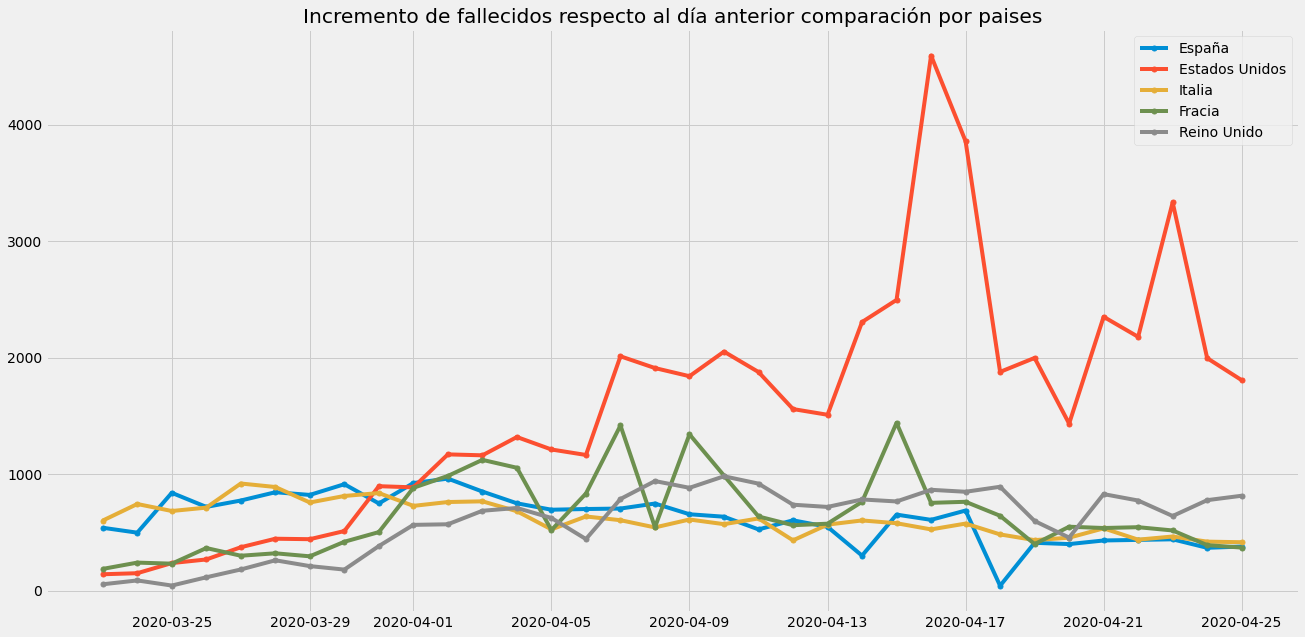

In [74]:
start, end = '2020-03-23 00:00:00', data_jh[(data_jh["Country/Region"] == "Spain") & (data_jh["Fallecidos"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_jh[(data_jh["Country/Region"] == "Spain") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_jh[(data_jh["Country/Region"] == "US") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_jh[(data_jh["Country/Region"] == "Italy") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_jh[(data_jh["Country/Region"] == "France") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_jh[(data_jh["Country/Region"] == "United Kingdom") & (data_jh["Fallecidos"] > 10)].loc[start:end, 'Diferencia fallecidos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento de fallecidos respecto al día anterior comparación por paises");
ax.legend();

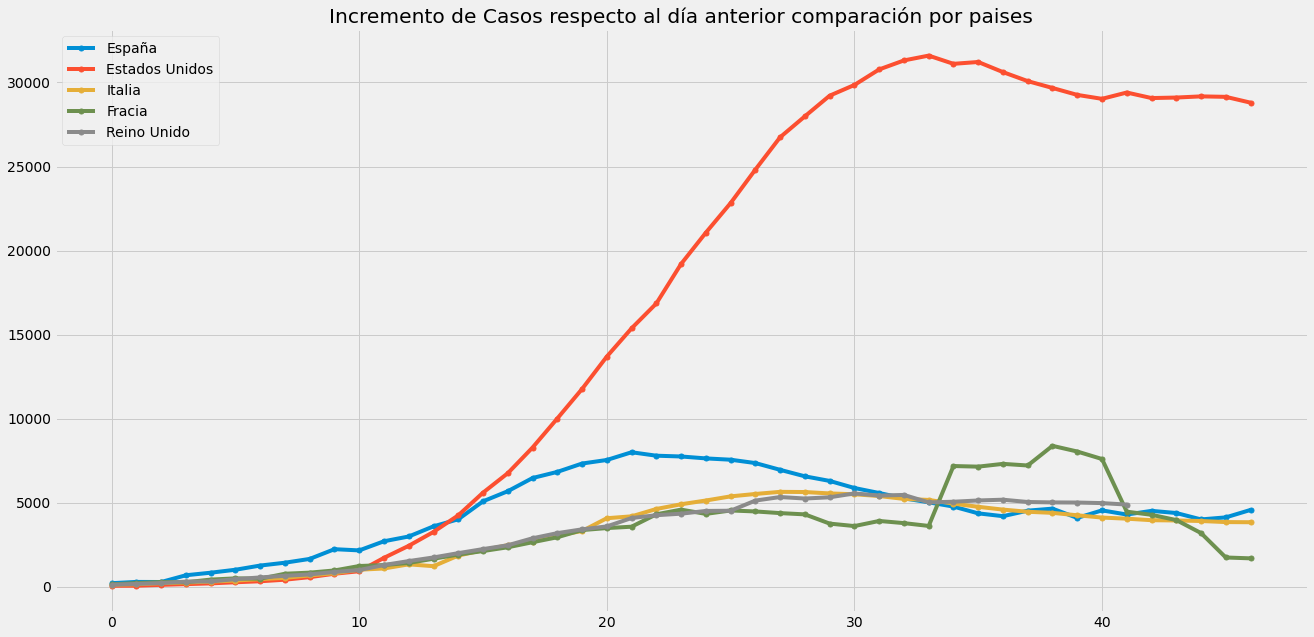

In [75]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Diferencia casos dia anterior'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento de Casos respecto al día anterior comparación por paises");
ax.legend();

In [76]:
data_jh[["Country/Region","Diferencia casos dia anterior"]].sort_values("Diferencia casos dia anterior",
                                                                            ascending=False).head(10)

,Country/Region,Diferencia casos dia anterior
Fecha,,
2020-04-24,US,36188.0
2020-04-09,US,34126.0
2020-04-10,US,33755.0
2020-04-04,US,33283.0
2020-04-25,US,32796.0
2020-04-18,US,32491.0
2020-04-17,US,32114.0
2020-04-03,US,31745.0
2020-04-08,US,31533.0


In [77]:
data_jh[["Country/Region","Diferencia fallecidos dia anterior"]].sort_values("Diferencia fallecidos dia anterior",
                                                                            ascending=False).head(10)

,Country/Region,Diferencia fallecidos dia anterior
Fecha,,
2020-04-16,US,4592.0
2020-04-17,US,3857.0
2020-04-23,US,3332.0
2020-04-15,US,2495.0
2020-04-21,US,2350.0
2020-04-14,US,2305.0
2020-04-22,US,2178.0
2020-04-10,US,2051.0
2020-04-07,US,2011.0


In [78]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

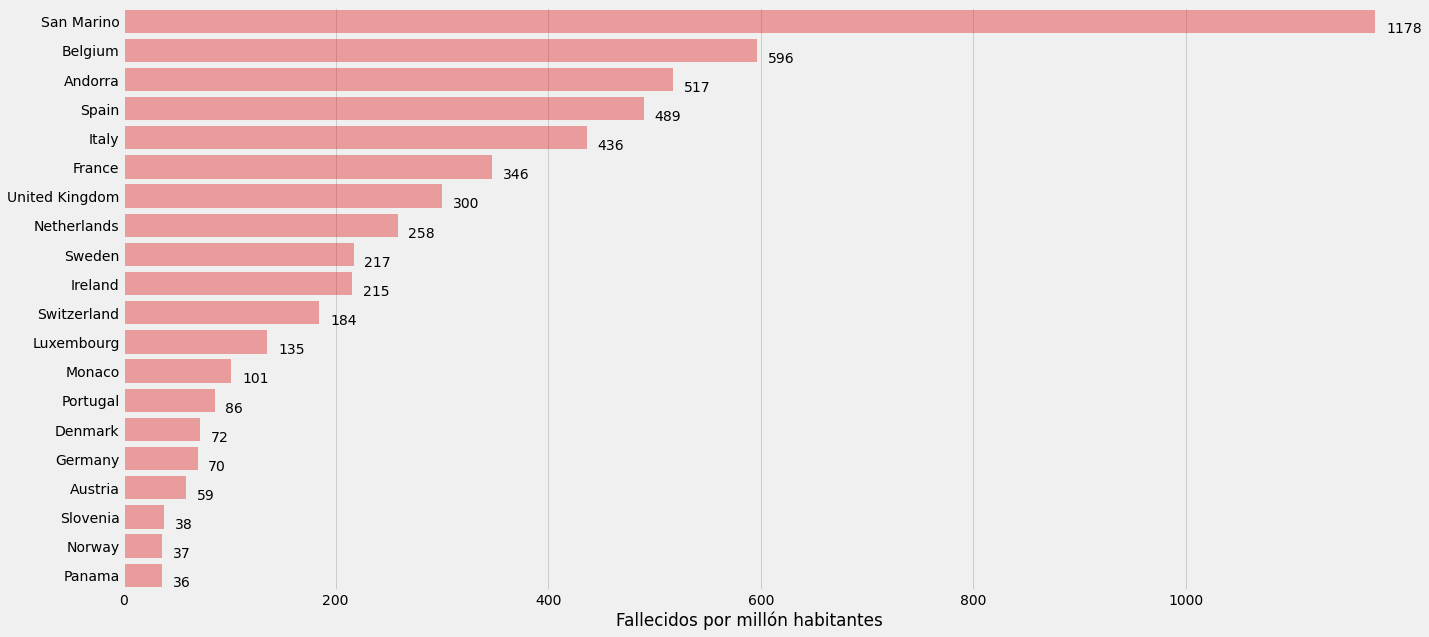

In [79]:

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(20,10))

# Load the example car crash dataset
df = data_jh.groupby(["Country/Region"]).max()["Fallecidos por millón habitantes"].sort_values(ascending=False).to_frame().reset_index().head(20)

# Plot the total crashes
sns.barplot(x="Fallecidos por millón habitantes", y="Country/Region", data=df,
            label="Total", color="r", alpha=0.4)



# Add a legend and informative axis label
ax.set(xlim=(0, df["Fallecidos por millón habitantes"].max()), ylabel="",
       xlabel="Fallecidos por millón habitantes")
show_values_on_bars(ax, "h", 10);


In [80]:
fecha = data_jh.index.max()

df = data_jh[data_jh["Fallecidos"] > 25].loc[fecha, ["Country/Region","Fallecidos",
                                                'Incremento porcentual de fallecidos respecto al total']].sort_values(by='Incremento porcentual de fallecidos respecto al total',
                                                                                                                      ascending=False).head(10)
df["Días que tarda en doblar fallecidos"] = 100/df["Incremento porcentual de fallecidos respecto al total"]

df["Días que tarda en doblar fallecidos"] = df["Días que tarda en doblar fallecidos"].round(3)
df["Incremento porcentual de fallecidos respecto al total"] = df["Incremento porcentual de fallecidos respecto al total"].round(3)

df

,Country/Region,Fallecidos,Incremento porcentual de fallecidos respecto al total,Días que tarda en doblar fallecidos
Fecha,,,,
2020-04-25,Mexico,1305,18.084,5.530
2020-04-25,Niger,27,11.111,9.000
2020-04-25,Congo (Kinshasa),28,10.714,9.333
2020-04-25,Moldova,94,10.638,9.400
2020-04-25,United Arab Emirates,71,9.859,10.143
2020-04-25,Russia,681,9.692,10.318
2020-04-25,Peru,700,9.429,10.606
2020-04-25,Brazil,4057,8.701,11.493
2020-04-25,Nigeria,35,8.571,11.667


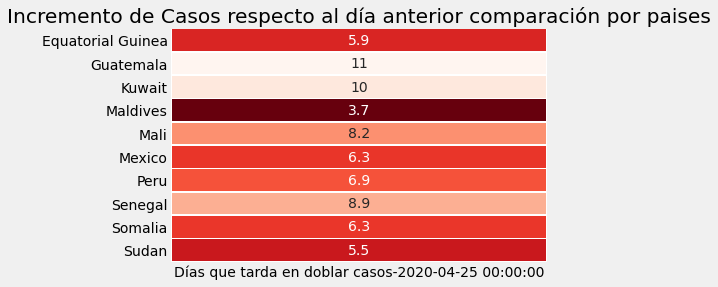

In [81]:
fecha = data_jh.index.max()

df = data_jh[data_jh["Casos"] > 100].loc[fecha, ["Country/Region","Casos",
                                                'Incremento porcentual de casos respecto al total']].sort_values(by='Incremento porcentual de casos respecto al total',
                                                                                                                      ascending=False).head(10)
df["Días que tarda en doblar casos"] = 100/df["Incremento porcentual de casos respecto al total"]

df["Días que tarda en doblar casos"] = df["Días que tarda en doblar casos"].round(3)
df["Incremento porcentual de casos respecto al total"] = df["Incremento porcentual de casos respecto al total"].round(3)
df = df.loc[:, df.columns != 'Casos']
df = df.loc[:, df.columns != 'Incremento porcentual de casos respecto al total']
df = df.sort_values(by='Días que tarda en doblar casos',ascending=False)
df = df.reset_index().pivot("Country/Region","Fecha")
ax = sns.heatmap(df, annot=True,cmap="Reds_r", linewidths=.5,cbar=False)
plt.title("Incremento de Casos respecto al día anterior comparación por paises")
plt.ylabel('')
plt.xlabel('');



In [82]:
df

,Días que tarda en doblar casos
Fecha,2020-04-25
Country/Region,
Equatorial Guinea,5.864
Guatemala,11.000
Kuwait,10.403
Maldives,3.688
Mali,8.222
Mexico,6.266
Peru,6.878
Senegal,8.899


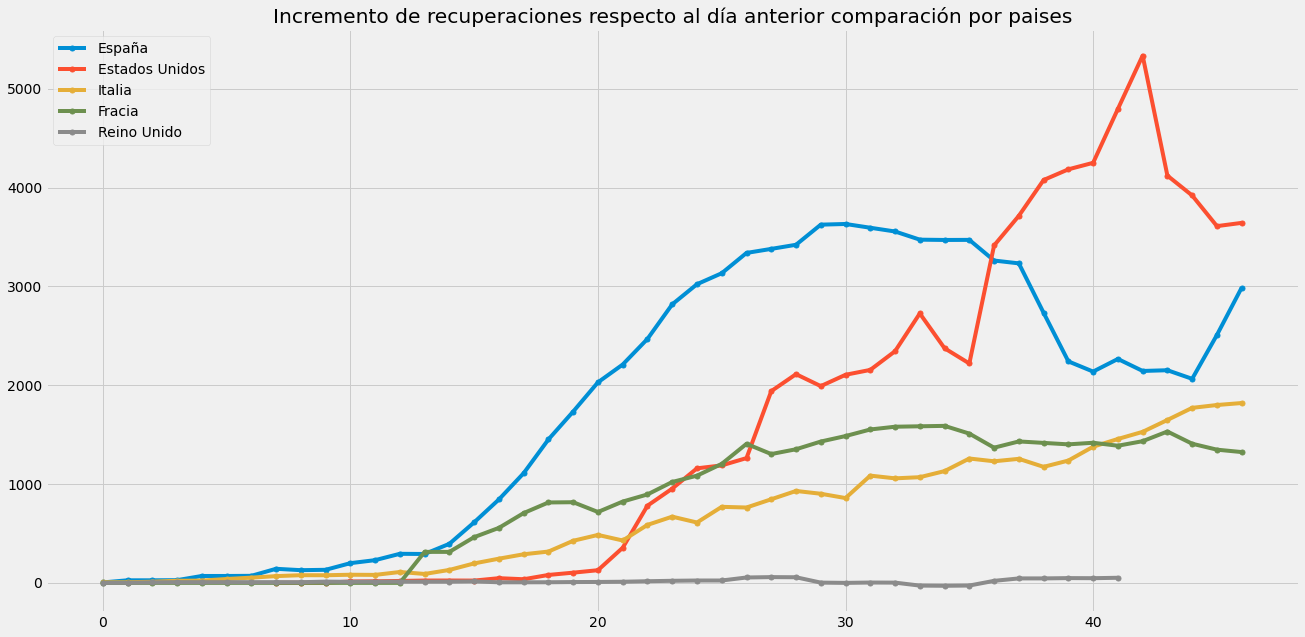

In [83]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Recuperados"] > 10)].loc[start:end, 'Diferencia recuperados dia anterior'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento de recuperaciones respecto al día anterior comparación por paises");
ax.legend();

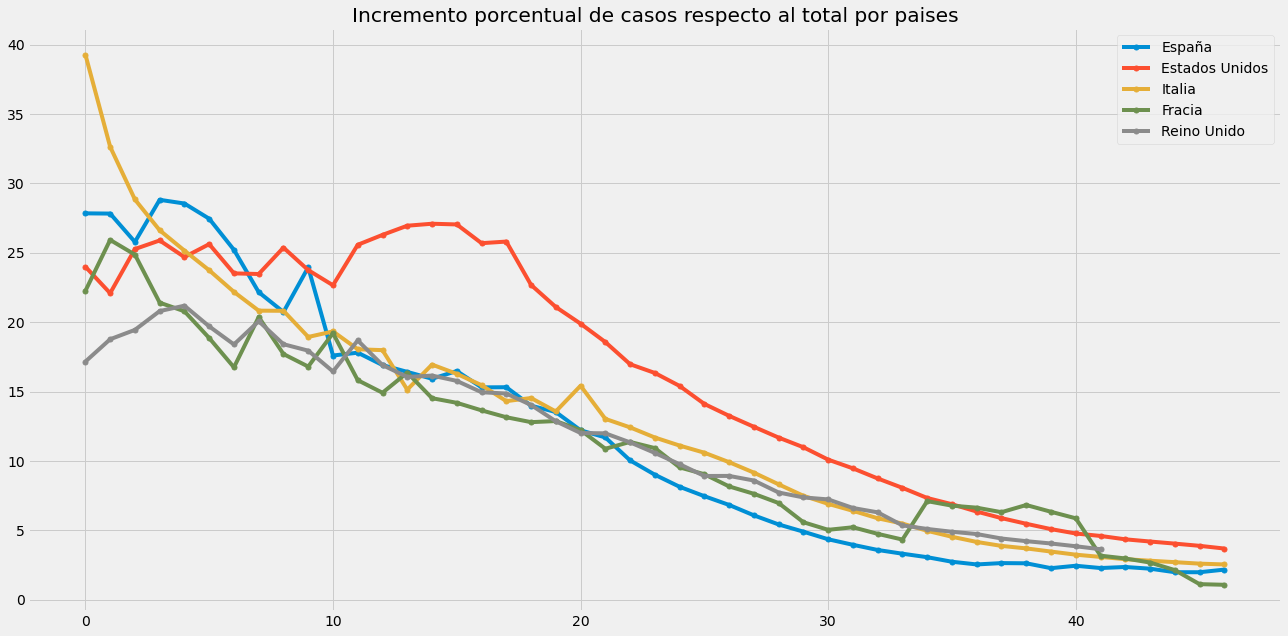

In [84]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Casos"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Casos"] > 10)].loc[start:end, 'Incremento porcentual de casos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento porcentual de casos respecto al total por paises");
ax.legend();

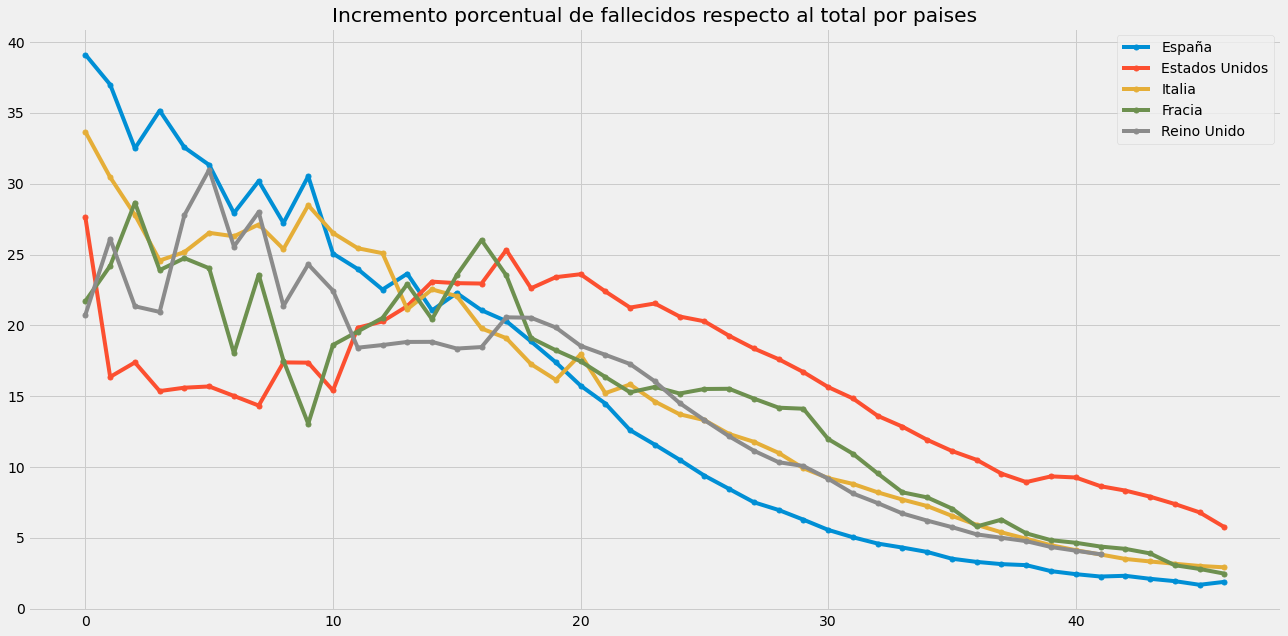

In [85]:
start, end = data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].index.min(), data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Recuperados"] > 10)].index.max()
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Spain") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='España')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "US") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Estados Unidos')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "Italy") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Italia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "France") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Fracia')
ax.plot(data_sem_jh[(data_sem_jh["Country/Region"] == "United Kingdom") & (data_sem_jh["Fallecidos"] > 10)].loc[start:end, 'Incremento porcentual de fallecidos respecto al total'],
marker='o', markersize=5, linestyle='-', label='Reino Unido')
plt.title("Incremento porcentual de fallecidos respecto al total por paises");
ax.legend();

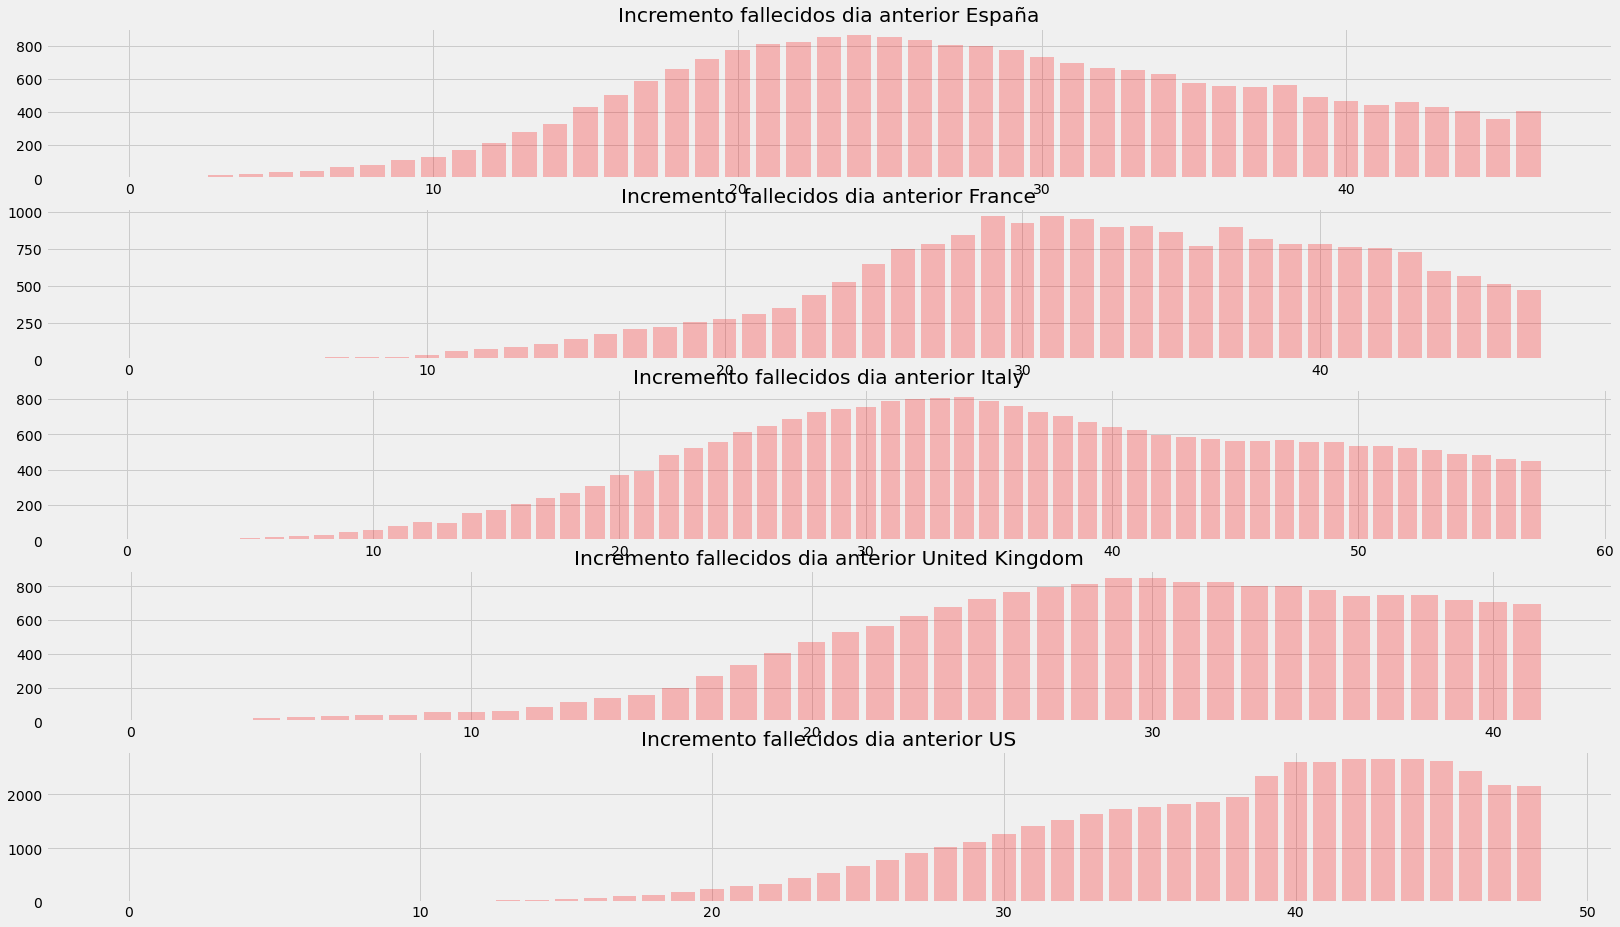

In [86]:
start, end = data_sem_jh.index.min(), data_sem_jh.index.max()
# Let's build our plot
# Set up plot 
fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(5,figsize=(25,15))

#Next lines plot the bar chat part of the plot
ax1.bar(data_sem_jh[data_sem_jh["Country/Region"] == "Spain"].loc[start: end].index, 
        data_sem_jh[data_sem_jh["Country/Region"] == "Spain"]["Diferencia fallecidos dia anterior"].loc[start: end],
        width=0.8, alpha=0.25, color='red')

ax2.bar(data_sem_jh[data_sem_jh["Country/Region"] == "France"].loc[start: end].index, 
        data_sem_jh[data_sem_jh["Country/Region"] == "France"]["Diferencia fallecidos dia anterior"].loc[start: end],
        width=0.8, alpha=0.25, color='red')

ax3.bar(data_sem_jh[data_sem_jh["Country/Region"] == "Italy"].loc[start: end].index, 
        data_sem_jh[data_sem_jh["Country/Region"] == "Italy"]["Diferencia fallecidos dia anterior"].loc[start: end],
        width=0.8, alpha=0.25, color='red')

ax4.bar(data_sem_jh[data_sem_jh["Country/Region"] == "United Kingdom"].loc[start: end].index, 

        data_sem_jh[data_sem_jh["Country/Region"] == "United Kingdom"]["Diferencia fallecidos dia anterior"].loc[start: end],
        width=0.8, alpha=0.25, color='red')

ax5.bar(data_sem_jh[data_sem_jh["Country/Region"] == "US"].loc[start: end].index, 
        data_sem_jh[data_sem_jh["Country/Region"] == "US"]["Diferencia fallecidos dia anterior"].loc[start: end],
        width=0.8, alpha=0.25, color='red')

ax1.grid(b=True) #Turn on grid

#set up the title and legend
ax1.set_title('Incremento fallecidos dia anterior España')
ax2.set_title('Incremento fallecidos dia anterior France')
ax3.set_title('Incremento fallecidos dia anterior Italy')
ax4.set_title('Incremento fallecidos dia anterior United Kingdom')
ax5.set_title('Incremento fallecidos dia anterior US');


In [87]:
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA


In [88]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
data_sem.index.freq="D"
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(np.log(data_sem["Diferencia fallecidos dia anterior"]),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
                        


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:279.1635237459489
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1029.0404429183432
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:176.301507942663
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:42.15153667278647
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:191.65190794126752
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1316.234090629596
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:32.62913936884733
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:29.08613635956221
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:226.09880587354215
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2295.17627009562
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:125.39057144054598
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3.0021047454437886
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:200.54514426257026
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2791.0614250120807
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:13.35463662800058
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:6.024666564715698
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-31.074210578628147
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1438.0929026920096
AR

In [89]:
mod2 = sm.tsa.statespace.SARIMAX(np.log(data_sem["Diferencia fallecidos dia anterior"]),
                                order=(0, 1, 0),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results2 = mod2.fit()
print(results2.summary())

                                       SARIMAX Results                                        
Dep. Variable:     Diferencia fallecidos dia anterior   No. Observations:                   49
Model:               SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                  17.960
Date:                                Sun, 26 Apr 2020   AIC                            -31.920
Time:                                        12:33:10   BIC                            -29.649
Sample:                                    03-08-2020   HQIC                           -31.349
                                         - 04-25-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L12       0.2498      0.325      0.768      0.442      -0.387       0.887
sig

2020-04-26    384.315098
2020-04-27    373.285446
2020-04-28    371.960558
2020-04-29    385.386958
2020-04-30    367.249446
2020-05-01    356.268577
2020-05-02    349.510289
2020-05-03    324.012606
2020-05-04    309.253095
2020-05-05    285.038864
Freq: D, dtype: float64


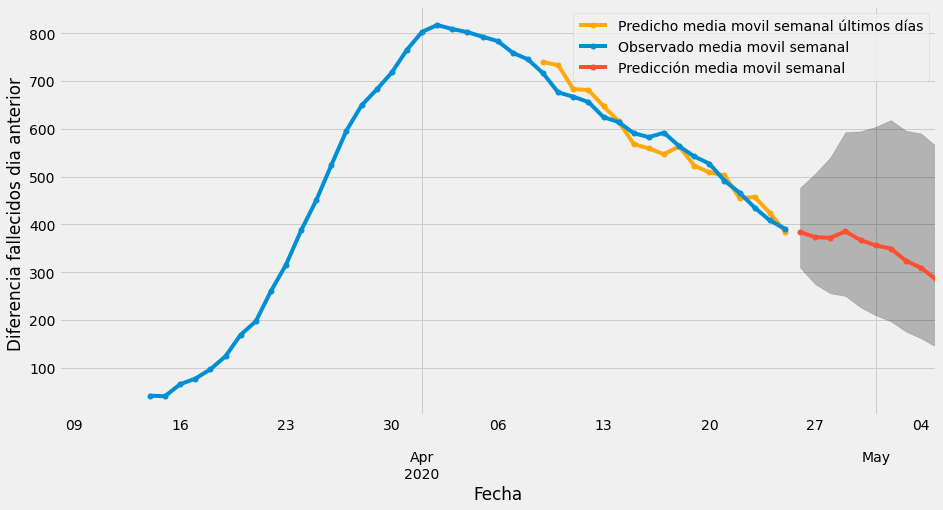

In [90]:
pred_uc_prev = results2.get_prediction(start=pd.to_datetime('2020-04-09 00:00:00'))

pred_uc_prev = math.e**pred_uc_prev.predicted_mean

ax = pred_uc_prev.plot( alpha=.95, figsize=(14, 7),color= "orange",
                       label='Predicho media movil semanal últimos días',marker='o', markersize=5)

pred_uc = results2.get_forecast(steps=10)

pred_ci = pred_uc.conf_int()
pred_ci = math.e**pred_ci
pred_uc = math.e**pred_uc.predicted_mean
ax = data_sem["Diferencia fallecidos dia anterior"].plot(label='Observado media movil semanal', figsize=(14, 7),marker='o', markersize=5)
pred_uc.plot(ax=ax, label='Predicción media movil semanal',marker='o', markersize=5)
print(pred_uc)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Diferencia fallecidos dia anterior ')
plt.legend()
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\predicción_media_movil.png');

plt.show()


In [91]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(np.log(data_es["Diferencia fallecidos dia anterior"]),order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
                        


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:308.89103260324316
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:239.68394645516287
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:135.76521377307273
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:nan
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:140.82242354071784
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:136.416769001952
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:32.30394673113573
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:nan
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:251.5876938816597
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:191.30197972063507
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:106.80041080450515
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:804.3973954642913
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:122.50796169720907
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:114.1336437747045
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:12.214247980487865
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:8.633000397990358
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:86.34353006976976
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1386.5849551388978
ARIMA(0, 1, 0)x(0, 1, 0, 12)12

In [92]:
mod = sm.tsa.statespace.SARIMAX(np.log(data_es["Diferencia fallecidos dia anterior"]),
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                       SARIMAX Results                                        
Dep. Variable:     Diferencia fallecidos dia anterior   No. Observations:                   49
Model:                SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                   2.997
Date:                                Sun, 26 Apr 2020   AIC                              2.006
Time:                                        12:33:27   BIC                              6.548
Sample:                                    03-08-2020   HQIC                             3.148
                                         - 04-25-2020                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7892      0.428     -1.845      0.065      -1.628       0.049
ma.

Fecha
2020-04-08    828.389286
2020-04-09    674.747482
2020-04-10    613.126246
2020-04-11    579.894944
2020-04-12    699.576586
2020-04-13    493.372982
2020-04-14    544.269676
2020-04-15    628.618524
2020-04-16    530.520177
2020-04-17    556.723785
2020-04-18    674.657431
2020-04-19    379.435101
2020-04-20    441.316480
2020-04-21    333.049168
2020-04-22    371.963696
2020-04-23    510.180219
2020-04-24    325.912260
2020-04-25    383.890535
Freq: D, dtype: float64
2020-04-26    338.109207
2020-04-27    326.176191
2020-04-28    292.977267
2020-04-29    295.325902
2020-04-30    207.112169
2020-05-01    206.988502
2020-05-02    218.440770
2020-05-03    224.713196
2020-05-04    224.389947
2020-05-05    189.045920
Freq: D, dtype: float64


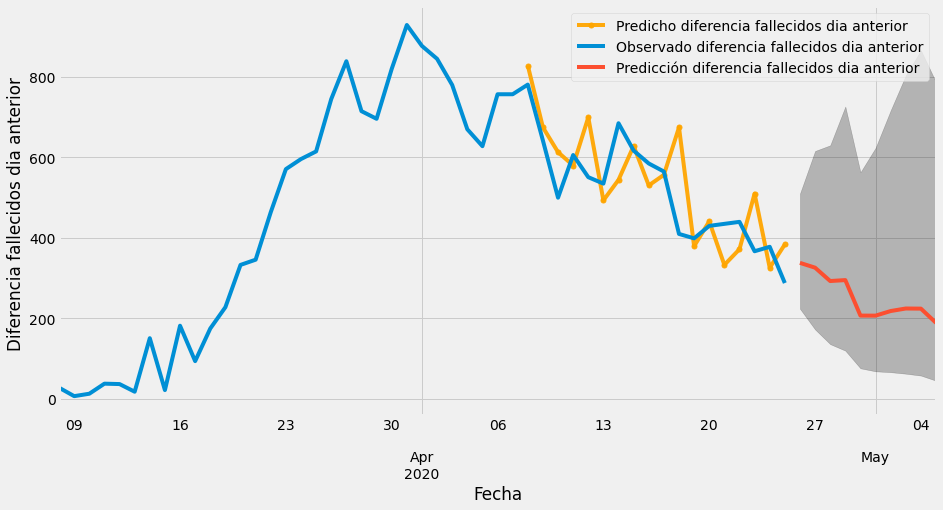

In [93]:
pred_uc_prev = results.get_prediction(start=pd.to_datetime('2020-04-08 00:00:00'))
pred_uc_prev = math.e**pred_uc_prev.predicted_mean

print(pred_uc_prev)

ax = pred_uc_prev.plot( alpha=.95, figsize=(14, 7),color= "orange",
                       label='Predicho diferencia fallecidos dia anterior',marker='o', markersize=5)

pred_uc = results2.get_forecast(steps=10)


pred_uc = results.get_forecast(steps=10)

pred_ci = pred_uc.conf_int()
pred_ci = math.e**pred_ci
pred_uc = math.e**pred_uc.predicted_mean
ax = data_es["Diferencia fallecidos dia anterior"].plot(label='Observado diferencia fallecidos dia anterior', figsize=(14, 7))
pred_uc.plot(ax=ax, label='Predicción diferencia fallecidos dia anterior')
print(pred_uc)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Fecha')
ax.set_ylabel('Diferencia fallecidos dia anterior ')
plt.savefig(r'C:\Users\guillermo.arguello\Documents\GitHub\covid19_spain\resources\imagenes\predicción.png')

plt.legend()
plt.show()

In [94]:
from statsmodels.formula.api import ols
data_mad= data_mad[data_mad["fecha_informe"] == data_mad["fecha_informe"].max()]
results = ols('tasa_incidencia_acumulada_total ~ data_mad["Renta Categorical"] ', data=data_mad).fit()
table = sm.stats.anova_lm(results)
table

,df,sum_sq,mean_sq,F,PR(>F)
"data_mad[""Renta Categorical""]",4.0,8.596426e+05,214910.658136,2.695237,0.035469
Residual,94.0,7.495298e+06,79737.211710,NaN,NaN


In [95]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     tasa_incidencia_acumulada_total   R-squared:                       0.103
Model:                                         OLS   Adj. R-squared:                  0.065
Method:                              Least Squares   F-statistic:                     2.695
Date:                             Sun, 26 Apr 2020   Prob (F-statistic):             0.0355
Time:                                     12:33:28   Log-Likelihood:                -696.59
No. Observations:                               99   AIC:                             1403.
Df Residuals:                                   94   BIC:                             1416.
Df Model:                                        4                                         
Covariance Type:                         nonrobust                                         
======================================================================================================================
                                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------
Intercept                                            839.8376     68.487     12.263      0.000     703.856     975.820
data_mad["Renta Categorical"][T.Renta Baja]           79.4574    106.467      0.746      0.457    -131.935     290.850
data_mad["Renta Categorical"][T.Renta Media-Alta]   -140.6384    101.911     -1.380      0.171    -342.986      61.709
data_mad["Renta Categorical"][T.Renta Media-Baja]   -155.3055     86.823     -1.789      0.077    -327.694      17.083
data_mad["Renta Categorical"][T.Renta Media-Media]  -184.1569     86.823     -2.121      0.037    -356.545     -11.768
==============================================================================
Omnibus:                        3.908   Durbin-Watson:                   1.448
Prob(Omnibus):                  0.142   Jarque-Bera (JB):                3.889
Skew:                           0.475   Prob(JB):                        0.143
Kurtosis:                       2.796   Cond. No.                         6.39
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""